# Calculating MPE and Qual statistical levels from "flight" data

## Theoretical background

This notebook compares two methods to compute "MPE" (maximum predicted environment) and "Qual" levels from simulated flight data. The simulated flight data could be for a shock response spectrum (SRS) level at some frequency. In this notebook, MPE is the "P95/50" level and Qual is the "P99/90" level. In other words, the MPE level will have a 50% chance of bounding 95% of the population and the Qual level will have a 90% chance of bounding 99% of the population. The first number (95% for example) can be called the normal probability limit, and the second number (50% for example) can be called the confidence level. The equations for both methods are related to each other and are derived below following Owen [1].

The first method is to assume that the standard deviation of the population is 3 dB. This has been used in MIL-STD-1540 and is still maintained in "SMC Standard SMC-S-016" [2]. It is further supported by Yunis [3]. Method 1 will use the equation:

$$Level_1 = \bar{x}_g + (Z_p + \frac{Z_c}{\sqrt{n}})\, \sigma$$

where $\bar{x}_g$ is the sample geometric mean (see below), $Z_p$ is the number standard deviations to go from the mean to the normal probability limit, $Z_c$ is the number standard deviations to go from the mean to the confidence level, and $n$ is the number of samples. For a P95/50 level, if $F_N$ is the cumulative distribution function for the normal distribution:

$$P_p = 0.95$$
$$Z_p = F_N^{-1}(P_p) = \text{scipy.stats.norm.ppf}(P_p) = 1.64$$

$$P_c = 0.50$$
$$Z_c = F_N^{-1}(P_c) = \text{scipy.stats.norm.ppf}(P_c) = 0.0$$

where $P_p$ is the normal probability level and $P_c$ is the confidence level.

The second method is to use normal tolerance limits to compute the statistical bounds. Specifically, we'll use the function ``pyyeti.stats.ksingle``. We'll show that the two methods can be equivalent if two conditions are met: the simulated flight sample standard deviation is 3 dB (as assumed in the first method), and we have enough flights for an accurate estimate of the standard deviation. We'll also explore what happens for fewer flights. This has been explored previously [3]. Method 2 will use the noncentral *t*-distribution. If $F_T$ is the cumulative distribution function of the noncentral *t*-distribution, then:

$$Level_2 = \bar{x}_g + \frac{F_T^{-1}(P_c, n-1, Z_p \sqrt{n})}{\sqrt{n}}\, s = \bar{x}_g + \text{pyyeti.stats.ksingle}(P_p, P_c, n)\, s$$

where $s$ is the sample standard deviation in dB, and the value $Z_p \sqrt{n}$ is the noncentrality parameter.


References:

[1] D. B. Owen, "Factors for One-Sided Tolerance Limits and for Variables Sampling Plans", SCR-607, Mathematics and Computers, TID-4500 (19th Edition), Sandia Corporation Monograph, March 1963.

[2] SMC-S-016 (2014), Air Force Space Command, Space and Missile Systems Center Standard, "Test Requirements for Launch, Upper-Stage, and Space Vehicles (05-SEP-2014) Superseding SMC-S-016 (2008).

[3] Isam Yunis, "Standard Deviation of Launch Vehicle Vibration and Acoustic Environments", Journal of Spacecraft and Rockets, Vol. 50, No. 4, July–August 2013.

### What is a dB?

The equation for computing how many dB's it is from $value_1$ to $value_2$ is:

$$d = 20 \log_{10}(\frac{value_2}{value_1}) \, \text{dB}$$

Rearranging that equation, we have:

$$value_2 = value_1 \cdot 10^{d/20}$$
    
Therefore, when $d$ dB is "added" to a number, it really means to multiply the number by $10^{d/20}$. For example, to add $6 \, \text{dB}$ is to approximately double a value:

$$value_2 = value_1 + 6 \, \text{dB} = value_1 \cdot 10^{6/20} \approx 2 \cdot value_1$$

#### Aside

It is noted that for squared quantities $value_1$ and $value_2$ (as in "power" units), the 20 becomes 10 because the power of 2 is inside the log.

### What does it mean to specify the standard deviation in dB?

When the standard deviation is specified in dB, it really means that the data is assumed to follow a log-normal distribution. The following shows how this math works.

Let's look at the calculation of an "$k \sigma$" level (where $\mu$ is the arithmetic mean) of normally distributed data:

$$level = \mu + k \sigma$$

If $\sigma$ is in dB, then, as we saw above, that equation is really:

$$level = \mu_g \cdot 10^{k \sigma / 20}$$

We're using $\mu_g$ instead of $\mu$ to denote that this is the geometric mean (as we'll show below).

So, if $k$ is 2 and $\sigma$ is 3 dB, then the 2-sigma level is approximately twice the mean. Clearly, this is not a normal distribution where $k \sigma$ would be *added* to the mean. However, multiplication becomes addition in log space. So, to put in a more standard form, take the logarithm of both sides of the previous equation:

$$\log_{10}(level) = \log_{10}(\mu_g \cdot 10^{k \sigma / 20})$$

$$\log_{10}(level) = \log_{10}(\mu_g) + \log_{10}(10^{k \sigma / 20})$$

$$\log_{10}(level) = \log_{10}(\mu_g) + k \sigma / 20$$

$$\log_{10}(level) = \log_{10}(\mu_g) + k \sigma_{log_{10}}$$

Therefore, the standard deviation of the log10 of the data ($\sigma_{log_{10}}$) is related to standard deviation in dB ($\sigma$) by:

$$\sigma_{log_{10}} = \sigma / 20$$

(Note: the natural logarithm could have been used as well. In that case: $\sigma_{log_e} = \sigma / 20 \log_e(10)$. This fact will be used below to generate log-normal random deviates with ``scipy.stats.lognorm.rvs``.)

Consider the "mean" term. If the data are assumed to follow the log-normal distribution, then that term is the mean of the log of the data ($\mu_{log_{10}}$):

$$\log_{10}(\mu_g) = \mu_{log_{10}} = \frac{\log_{10}(x_1) + \log_{10}(x_2) ... + \log_{10}(x_n)}{n} = \log_{10}((x_1 \cdot x_2 \cdot ... x_n)^{1/n})$$

Therefore:

$$\mu_g = (x_1 \cdot x_2 \cdot ... x_n)^{1/n}$$

So $\mu_g$ is the geometric mean of the data.

### Theoretical background on single sided tolerance limits for normal distributions

We wish to calculate a limit that bounds some portion of the population with a some level of confidence. If we knew the population mean and standard deviation, the limit could be calculated easily with 100% confidence:

$$limit = \mu + Z_p \sigma$$

In our case however, we do not know these values, so we wish to find a value $k$ such that:

$$Pr\{\bar{x} + k \, s \geq \mu + Z_p \sigma\} = P_c~~~~~~~~~~~~~~~~~~(1)$$

where $\bar{x}$ is the sample mean and $s$ is the sample standard deviation.

It is known that the sample mean follows the normal distribution $\mathcal{N}(\mu, \sigma^2 / n)$. It is also known that $(n-1)s^2/\sigma^2$ follows a Chi-square distribution with degrees-of-freedom $n-1$:

$$(n-1)s^2/\sigma^2 \sim \chi^2_{n-1}$$

Rearranging equation (1):

$$Pr\left \{\frac{\bar{x}-\mu}{\sigma} + \frac{k \, s}{\sigma} \geq Z_p \right \} = P_c$$

$$Pr\left \{\frac{\mu - \bar{x}}{\sigma} + Z_p \leq \frac{k \, s}{\sigma}\right \} = P_c$$

$$Pr\left \{\frac{\mu - \bar{x}}{\frac{\sigma}{\sqrt{n}}} + Z_p \sqrt{n} \leq \frac{k \, s}{\sigma} \sqrt{n}\right \} = P_c$$

$$Pr\left \{
        \frac{\frac{\mu - \bar{x}}{\sigma / \sqrt{n}} + Z_p \sqrt{n}}
             {s /\sigma}
           \leq k \sqrt{n} \right \} = P_c~~~~~~~~~~~~~~~~~~(2)$$

The form of equation (2) is desirable because it is in the form of the noncentral *t*-distribution [4]. If $G$ is a normally distributed random variable with unit variance and zero mean, and $V$ is a Chi-squared distributed random variable with $n-1$ degrees of freedom that is independent of $G$, then:

$$T = \frac{G + \delta}{\sqrt{V / (n-1)}}$$

is a noncentral *t*-distributed random variable with $n-1$ degrees of freedom and noncentrality parameter $\delta \neq 0$. Note that the noncentrality parameter may be negative. In our case:

$$G = \frac{\mu - \bar{x}}{\sigma / \sqrt{n}}$$

$$\delta = Z_p \sqrt{n}$$

$$V = (n-1)s^2/\sigma^2$$

Reference:

[4] https://en.wikipedia.org/wiki/Noncentral_t-distribution

### Deriving the k factor for method 1:

In the case where we assume $\sigma$ is 3 dB, then we do not compute $s$ from the sample and just set $s = \sigma$. Equation (2) becomes:

$$Pr\left \{\frac{\mu - \bar{x}}{\sigma / \sqrt{n}} \leq (k - Z_p) \sqrt{n} \right \} = P_c$$

The first fraction in that equation follows the standard normal distribution: $\mathcal{N}(0, 1)$. Therefore:

$$(k - Z_p) \sqrt{n} = Z_c$$

$$k = Z_p + Z_c / \sqrt{n}$$

### Deriving the k factor for method 2:

To find the $k$ factor for method 2, we do not assume we know $\sigma$. In that case, equation (2) is in the form of the noncentral *t*-distribution and can be written:

$$Pr\left \{T_{n-1,\,\delta =Z_p \sqrt{n}} \leq k \sqrt{n} \right \} = P_c$$

where $T_{n-1,\,\delta =Z_p \sqrt{n}}$ is a noncentral *t* random variable with $n-1$ degrees-of-freedom and the noncentral parameter $Z_p \sqrt{n}$. Solving for $k$ gives the result shown above:

$$k = \frac{F_T^{-1}(P_c, n-1, Z_p \sqrt{n})}{\sqrt{n}}$$

## Exercises in Python

Some settings specifically for the jupyter notebook. This and other notebooks are available here: ``kittyhawk:/home/loads/twidrick/code/pyyeti/docs/tutorials``.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [2]:
%matplotlib inline
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, chi2
import pandas as pd
import pyyeti.stats

plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150.

### Exercise 1: Testing sample mean and variance distributions

When sampling a normally distributed random variable $\mathcal{N}(\mu, \sigma^2)$ , it was stated above that the sample mean follows the distribution:

$$\bar{x} \sim \mathcal{N}(\mu, \sigma^2 / n)$$

and that $(n-1)s^2/\sigma^2$ follows a Chi-square distribution with degrees-of-freedom $n-1$:

$$(n-1)s^2/\sigma^2 \sim \chi^2_{n-1}$$

This will be demonstrated in the following cell where the theory is compared to the results from a simple simulation:

1. Repeat the following `n_simulations` times:

    1. Generate `sample_size` pseudo random deviates that follow a normal distribution
    2. Compute the sample mean and sample variance

2. Plot a histograms of the results and compare to theoretical distributions

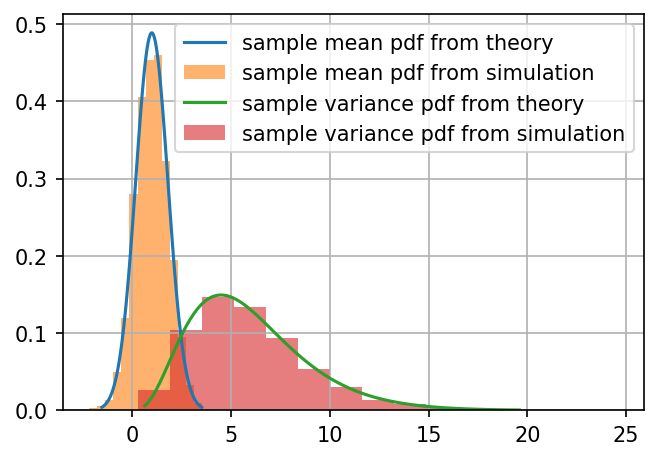

In [3]:
var = 6.0
n = 9
mu = 1.0
df = n - 1

n_simulations = 3000
sample_size = n

mean_s = np.empty(n_simulations)
var_s = np.empty(n_simulations)

for i in range(n_simulations):
    x = np.random.randn(sample_size) * np.sqrt(var) + mu
    mean_s[i] = x.mean()
    var_s[i] = x.var(ddof=1)

# for plot:
N = 100
fig = plt.figure()
ax = fig.subplots(1, 1)

# plot theoretical mean distribution:
scale = np.sqrt(var / n)
x = np.linspace(
    norm.ppf(0.001, loc=mu, scale=scale), norm.ppf(0.999, loc=mu, scale=scale), N
)
lines = []  # keep track of handles so legend is in desired order
lines += ax.plot(
    x, norm.pdf(x, loc=mu, scale=scale), label="sample mean pdf from theory"
)

# plot simulation mean distribution:
lines += ax.hist(
    mean_s,
    density=True,
    histtype="stepfilled",
    bins=15,
    alpha=0.6,
    label="sample mean pdf from simulation",
)[2]

# plot theoretical variance distribution:
scale = var / df
x = np.linspace(chi2.ppf(0.001, df, scale=scale), chi2.ppf(0.999, df, scale=scale), N)
lines += ax.plot(
    x, chi2.pdf(x, df, scale=scale), label="sample variance pdf from theory"
)

# plot simulation variance distribution:
lines += ax.hist(
    var_s,
    density=True,
    histtype="stepfilled",
    bins=15,
    alpha=0.6,
    label="sample variance pdf from simulation",
)[2]
ax.legend(handles=lines)

### Exercise 2: Show that both methods yield same k-factor with enough samples

As the number of samples increase, confidence approaches 100%. This means that the k-factor should approach $Z_p$.

To begin, define desired statistical levels. These will be used below as well.

In [4]:
levels = {
    "Mean": (0.50, 0.50),
    "MPE": (0.95, 0.50),
    "Qual": (0.99, 0.90),
}

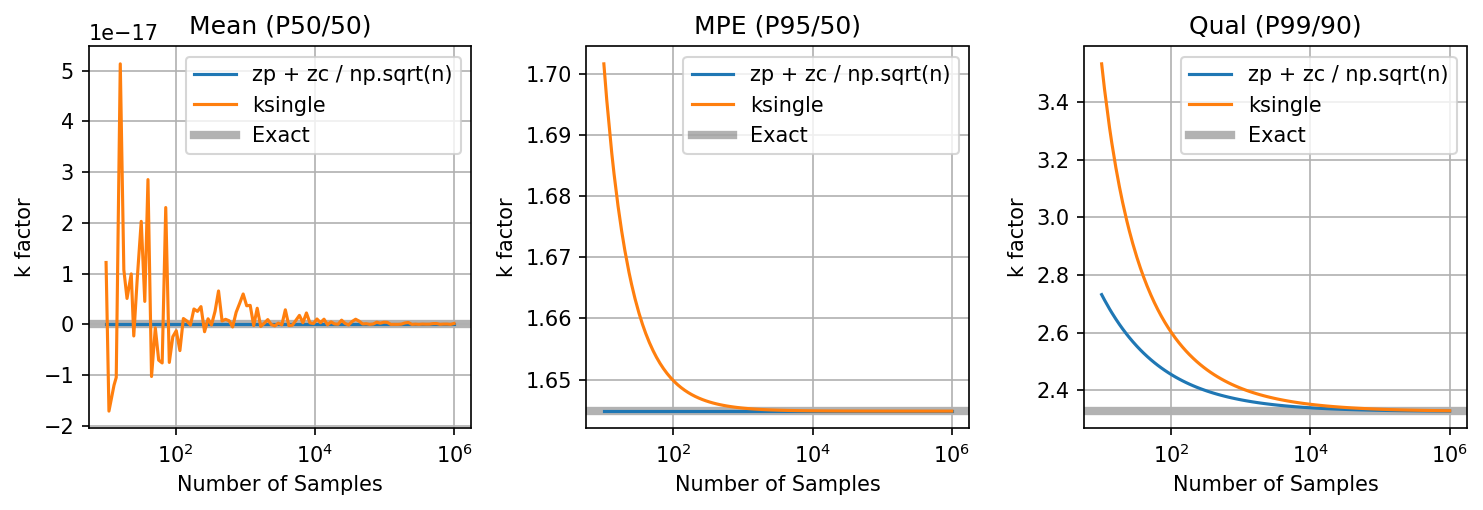

In [5]:
fig = plt.figure(figsize=(10, 3.5))
axes = fig.subplots(1, 3)

n = np.round(np.logspace(1, 6, 100)).astype(int)
for ax, (level, (p, c)) in zip(axes, levels.items()):
    zp = norm.ppf(p)
    zc = norm.ppf(c)
    ax.semilogx(n, zp + zc / np.sqrt(n), label="zp + zc / np.sqrt(n)")
    ax.semilogx(n, pyyeti.stats.ksingle(p, c, n), label="ksingle")
    ax.axhline(zp, color="black", alpha=0.3, linewidth=4, label="Exact", zorder=-1)
    ax.legend()
    ax.set_title(f"{level} (P{p*100:g}/{c*100:g})")
    ax.set_ylabel("k factor")
    ax.set_xlabel("Number of Samples")
fig.tight_layout()

### Exercise 3: How many samples are needed for estimating MPE and Qual levels from flight data?

This exercise is not difficult, but there are a number of steps involved. After running an earlier version of this notebook which only used $\sigma = 3 \text{dB}$, it was decided to also look at $\sigma = 1.5 \text{dB}$. Here is an outline:

1. Define analysis parameters: the geometric mean, sample sizes, the number of simulations, and the assumed standard deviations in dB. A 10,000 sample size is included to confirm that the simulations approach the "exact" value if enough samples are included.

2. Generate a pandas DataFrame to store simulation results. Care was taken to have nice plot labels:

    1. "Set σ" means using method 1 above, where $\sigma$ is assumed known and $k = Z_p + Z_c / \sqrt{n}$
    2. "NTL" means using method 2 above, where $k$ is the normal tolerance limit factor computed by using the noncentral *t*-distribution (``pyyeti.stats.ksingle``).
    
3. Run simulation to fill DataFrame with results. Log normal random deviates are generated to simulate flight data, using the parameters defined above. Then, both methods are used to estimate MPE (P95/50) and Qual (P99/90) levels. The mean of the estimate and the standard deviation of the estimate are stored in the DataFrame for plotting the results with error bars (in steps 5 and 6). The error bars will show the standard deviation of the estimate: large error bars indicate that more samples may be needed. For example, if there are 1000 simulations to compute the MPE level, the bar height is set to the mean of the 1000 estimates, and the error bars are set to the standard deviation of the 1000 estimates.

4. Look at some of the results. Ratio to exact is computed as well to gain more understanding of convergence.

5. Plot results, part 1. The first set of 6 plots will compare the estimates of the two methods for the mean, MPE and Qual levels for both the 1.5dB and 3.0dB standard deviations.

6. Plot results, part 2. The next plot will compare the variation of the Qual level estimate from both the 1.5dB and 3.0dB standard deviations.
    
7. Draw some conclusions

In [6]:
# Step 1: Define analysis parameters
geomean = 10.0
mu = np.log10(geomean)

sample_sizes = np.r_[2:10, 10_000]
n_simulations = 1000

stddevs = [1.5, 3.0]

In [7]:
# Step 2: Generate a pandas DataFrame to store simulation results

# lowest level labels chosen like this for nice legend labels:
def Set_lbl(stddev):
    return f"Set σ (σ={stddev}dB)"


def NTL_lbl(stddev):
    return f"NTL (σ={stddev}dB)"


col_labels = []
for stddev in stddevs:
    col_labels.append(Set_lbl(stddev))
    col_labels.append(NTL_lbl(stddev))

cols = pd.MultiIndex.from_product(
    [["Mean", "MPE", "Qual"], ["Level Estimate", "Estimate StdDev"], col_labels],
    names=["Limit", "Statistic", "Method"],
)
df = pd.DataFrame(index=sample_sizes, columns=cols)
df.index.name = "Number of Samples"
df = df.astype(float)

In [8]:
# look at first 8 columns (the "Mean" section) to see layout:
df.iloc[:, :8]

Limit                        Mean                                              \
Statistic          Level Estimate                                               
Method            Set σ (σ=1.5dB) NTL (σ=1.5dB) Set σ (σ=3.0dB) NTL (σ=3.0dB)   
Number of Samples                                                               
2                             NaN           NaN             NaN           NaN   
3                             NaN           NaN             NaN           NaN   
4                             NaN           NaN             NaN           NaN   
5                             NaN           NaN             NaN           NaN   
6                             NaN           NaN             NaN           NaN   
7                             NaN           NaN             NaN           NaN   
8                             NaN           NaN             NaN           NaN   
9                             NaN           NaN             NaN           NaN   
10000                         NaN           NaN             NaN           NaN   

Limit                                                                          
Statistic         Estimate StdDev                                              
Method            Set σ (σ=1.5dB) NTL (σ=1.5dB) Set σ (σ=3.0dB) NTL (σ=3.0dB)  
Number of Samples                                                              
2                             NaN           NaN             NaN           NaN  
3                             NaN           NaN             NaN           NaN  
4                             NaN           NaN             NaN           NaN  
5                             NaN           NaN             NaN           NaN  
6                             NaN           NaN             NaN           NaN  
7                             NaN           NaN             NaN           NaN  
8                             NaN           NaN             NaN           NaN  
9                             NaN           NaN             NaN           NaN  
10000                         NaN           NaN             NaN           NaN

In [9]:
# Step 3: Run simulation to fill DataFrame with results:
exact = {}
for stddev in stddevs:
    sigma = stddev / 20  # log10 sigma
    exact[stddev] = {}

    for n in sample_sizes:
        for level, (p, c) in levels.items():
            method1 = np.empty(n_simulations)
            method2 = np.empty(n_simulations)
            zp = norm.ppf(p)  # 1.64 for p == 0.95
            zc = norm.ppf(c)  # 0.0 for c == 0.50
            k1 = zp + zc / np.sqrt(n)
            k2 = pyyeti.stats.ksingle(p, c, n)
            exact[stddev][level] = 10 ** (mu + zp * (stddev / 20))
            for i in range(n_simulations):
                # generate lognormal deviates; here are two ways:
                # X_flight = 10 ** (sigma * np.random.randn(n) + mu)
                # X_flight = lognorm.rvs(size=n, s=np.log(10)*sigma, scale=geomean)
                X_flight = lognorm.rvs(size=n, s=np.log(10)*sigma, scale=geomean)
                Y = np.log10(X_flight)
                m = Y.mean()
                s = Y.std(ddof=1)  # should ~= sigma = stddev / 20
                method1[i] = 10 ** (m + k1 * (stddev / 20))
                method2[i] = 10 ** (m + k2 * s)
            df.loc[
                n, (level, ["Level Estimate", "Estimate StdDev"], Set_lbl(stddev))
            ] = (
                method1.mean(),
                method1.std(ddof=1),
            )
            df.loc[
                n, (level, ["Level Estimate", "Estimate StdDev"], NTL_lbl(stddev))
            ] = (
                method2.mean(),
                method2.std(ddof=1),
            )

In [10]:
# Step 4: Look at some of the results:
df['Mean']['Level Estimate']

Method,Set σ (σ=1.5dB),NTL (σ=1.5dB),Set σ (σ=3.0dB),NTL (σ=3.0dB)
Number of Samples,,,,
2,10.089639,10.089639,10.262116,10.262116
3,10.012438,10.012438,10.194587,10.194587
4,9.981561,9.981561,10.083669,10.083669
5,10.004064,10.004064,10.178215,10.178215
6,10.023690,10.023690,10.065060,10.065060
7,9.997134,9.997134,10.029880,10.029880
8,10.033189,10.033189,10.054137,10.054137
9,10.021465,10.021465,10.026342,10.026342
10000,9.999374,9.999374,9.999690,9.999690


In [11]:
df['MPE']['Level Estimate']

Method,Set σ (σ=1.5dB),NTL (σ=1.5dB),Set σ (σ=3.0dB),NTL (σ=3.0dB)
Number of Samples,,,,
2,13.334733,14.472553,17.905878,23.343842
3,13.361510,13.808916,18.084021,19.757833
4,13.391934,13.593642,17.919077,18.854445
5,13.330114,13.461595,17.959764,18.585369
6,13.286476,13.337375,17.826760,18.276500
7,13.317981,13.357889,17.742165,18.200931
8,13.303739,13.377617,17.753088,17.976356
9,13.293412,13.365341,17.662856,17.787271
10000,13.284054,13.285754,17.647110,17.647294


In [12]:
df['Qual']['Level Estimate']

Method,Set σ (σ=1.5dB),NTL (σ=1.5dB),Set σ (σ=3.0dB),NTL (σ=3.0dB)
Number of Samples,,,,
2,17.696060,3413.912926,31.910691,2.910442e+07
3,17.100145,38.089640,29.544118,2.320116e+02
4,16.714919,25.678941,28.458504,7.567083e+01
5,16.514002,22.262912,27.575953,5.322429e+01
6,16.310542,20.531723,27.066492,4.474818e+01
7,16.269153,19.732827,26.677919,4.164536e+01
8,16.132031,19.013720,26.254245,3.769927e+01
9,16.122028,18.713827,26.091309,3.606302e+01
10000,14.977086,15.007108,22.429363,2.253139e+01


In [13]:
# look at exact levels and then compute some ratios:
exact

{1.5: {'Mean': 10.0, 'MPE': 13.285075351411068, 'Qual': 14.944317663484906},
 3.0: {'Mean': 10.0, 'MPE': 17.649322709267, 'Qual': 22.333263042714684}}

In [14]:
# MPE, σ=1.5dB:
df['MPE']['Level Estimate'][['Set σ (σ=1.5dB)', 'NTL (σ=1.5dB)']] / exact[1.5]['MPE']

Method,Set σ (σ=1.5dB),NTL (σ=1.5dB)
Number of Samples,,
2,1.003738,1.089384
3,1.005753,1.039431
4,1.008044,1.023227
5,1.003390,1.013287
6,1.000105,1.003937
7,1.002477,1.005481
8,1.001405,1.006966
9,1.000627,1.006042
10000,0.999923,1.000051


In [15]:
# MPE, σ=3.0dB:
df['MPE']['Level Estimate'][['Set σ (σ=3.0dB)', 'NTL (σ=3.0dB)']] / exact[3.0]['MPE']

Method,Set σ (σ=3.0dB),NTL (σ=3.0dB)
Number of Samples,,
2,1.014536,1.322648
3,1.024630,1.119467
4,1.015284,1.068281
5,1.017589,1.053036
6,1.010054,1.035536
7,1.005260,1.031254
8,1.005879,1.018530
9,1.000767,1.007816
10000,0.999875,0.999885


In [16]:
# Qual, σ=1.5dB:
q15_to_exact = df['Qual']['Level Estimate'][['Set σ (σ=1.5dB)', 'NTL (σ=1.5dB)']] / exact[1.5]['Qual']
q15_to_exact

Method,Set σ (σ=1.5dB),NTL (σ=1.5dB)
Number of Samples,,
2,1.184133,228.442208
3,1.144257,2.548771
4,1.118480,1.718308
5,1.105036,1.489724
6,1.091421,1.373882
7,1.088651,1.320423
8,1.079476,1.272304
9,1.078807,1.252237
10000,1.002193,1.004202


In [17]:
# Qual, σ=3.0dB:
q30_to_exact = df['Qual']['Level Estimate'][['Set σ (σ=3.0dB)', 'NTL (σ=3.0dB)']] / exact[3.0]['Qual']
q30_to_exact

Method,Set σ (σ=3.0dB),NTL (σ=3.0dB)
Number of Samples,,
2,1.428841,1.303187e+06
3,1.322875,1.038861e+01
4,1.274265,3.388257e+00
5,1.234748,2.383185e+00
6,1.211936,2.003656e+00
7,1.194537,1.864723e+00
8,1.175567,1.688032e+00
9,1.168271,1.614767e+00
10000,1.004303,1.008871e+00


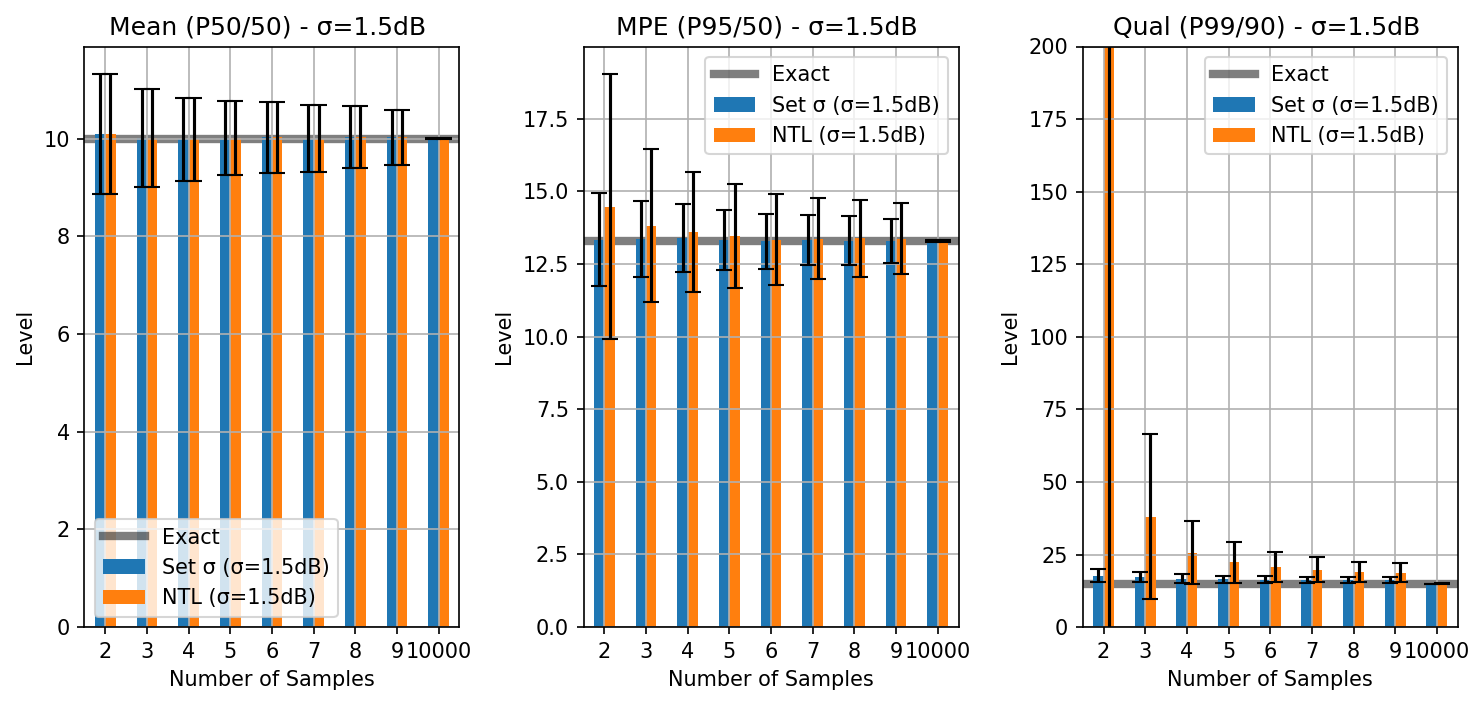

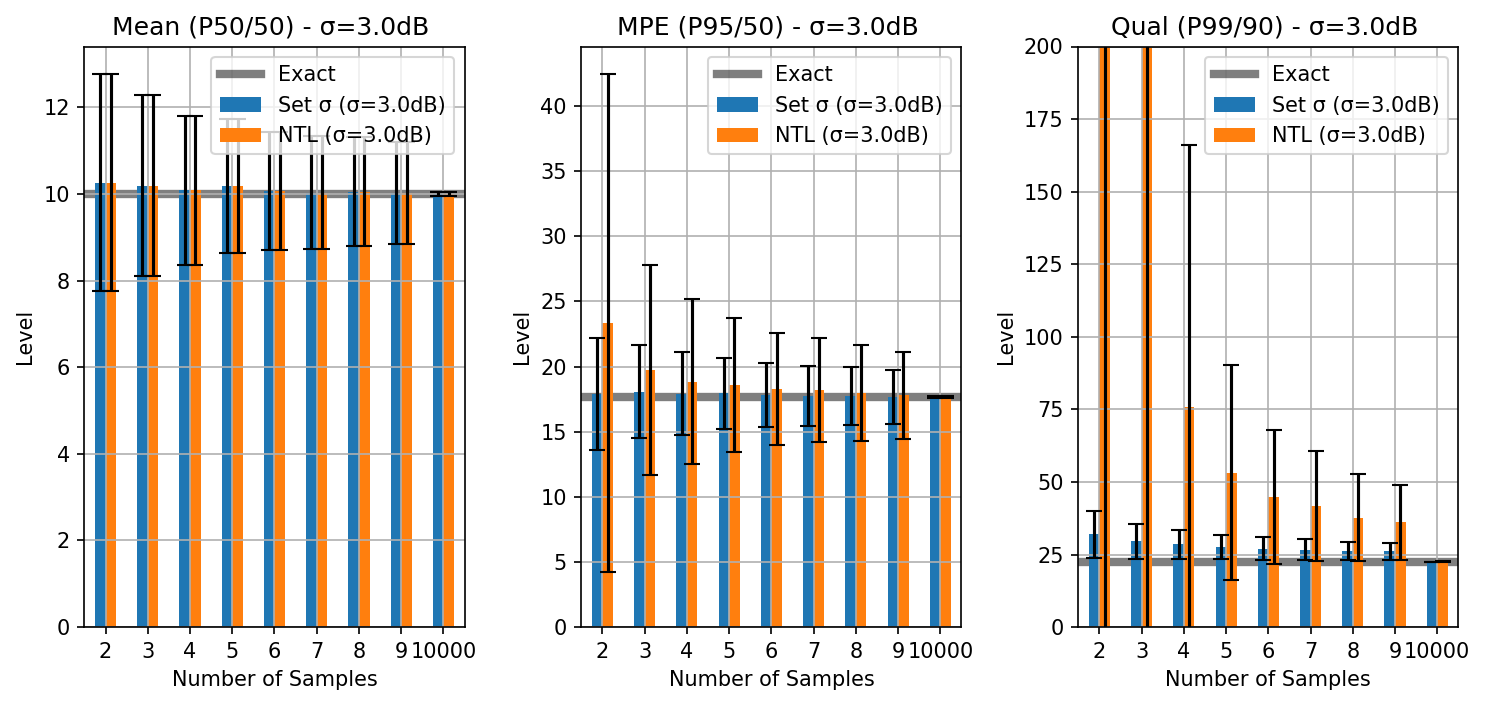

In [18]:
# 5. Plot results, part 1:
for stddev in stddevs:
    fig = plt.figure(figsize=(10, 4.8))
    axes = fig.subplots(1, 3)
    for ax, (level, (p, c)) in zip(axes, levels.items()):
        df[level]["Level Estimate"].plot.bar(
            ax=ax,
            y=[Set_lbl(stddev), NTL_lbl(stddev)],
            yerr=df[level]["Estimate StdDev"],
            capsize=4,
            rot=0,
        )

        ax.set_title(f"{level} (P{p*100:g}/{c*100:g}) - σ={stddev}dB ")
        ax.set_ylabel("Level")
        if ax.get_ylim()[1] > 200.0:
            ax.set_ylim(0, 200)

        ax.axhline(
            exact[stddev][level],
            color="black",
            alpha=0.5,
            linewidth=4,
            label="Exact",
            zorder=-1,
        )

        ax.legend()
        fig.tight_layout()

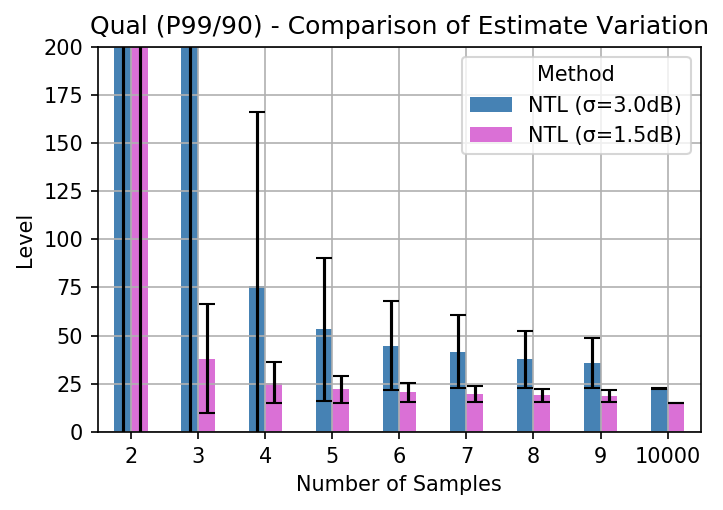

In [19]:
# 6. Plot results, part 2:
level = "Qual"
p, c = levels[level]

fig = plt.figure()
ax = fig.subplots(1, 1)
df[level]["Level Estimate"].plot.bar(
    ax=ax,
    y=[NTL_lbl(3.0), NTL_lbl(1.5)],
    yerr=df[level]["Estimate StdDev"],
    capsize=4,
    rot=0,
    color=["steelblue", "orchid"],
)

ax.set_title(f"{level} (P{p*100:g}/{c*100:g}) - Comparison of Estimate Variation")
ax.set_ylabel("Level")
if ax.get_ylim()[1] > 200.0:
    ax.set_ylim(0, 200)

fig.tight_layout()

Step 7: Draw some conclusions:

When using normal tolerance limits (NTL), there is a lot less variation in the results when estimating the mean or MPE levels than there is when estimating the Qual level. In other words, it takes significantly more samples to accurately estimate the Qual level than the MPE or mean levels. This shouldn't be too surprising: the Qual level is in the thinner part of the tail where data is naturally harder to come by. Requiring 90% confidence (meaning the estimate will be high 90% of the time) in this region has a large impact on the k-factor. For example, consider the extreme case of just two samples:

| Statistical Level | k-factor (from ``pyyeti.stats.ksingle``) |
| --- | --- |
| P95/50 | 2.339 |
| P99/50 | 3.376 |
| P95/90 | 13.09 |
| P99/90 | 18.50 |

From the above results, 2 flights seemed sufficient to get a reasonable estimate of the mean. For MPE, even if the standard deviation is as high as 3 dB, 5 flights was enough to bring the average estimate to within 5%. For Qual however, with a standard deviation of 3 dB, 9 flights only brought the average estimate to within about 60%. From other runs, it took approximately 20 flights to get within 25% (on average). If the standard deviation was 1.5 dB, 9 flights brought the average Qual estimate to within 25%.

It is interesting to look at the rate of improvement by adding samples. From the Qual plots and tables shown above, it is clear that adding a sample when there are very few samples helps significantly. However, the rate of improvement drops off quickly: the major gains by adding one sample have already taken place by ~6 samples for 1.5 dB and by ~9 samples for 3.0 dB. After that, significant gains require more and more samples. Here is a plot showing this:

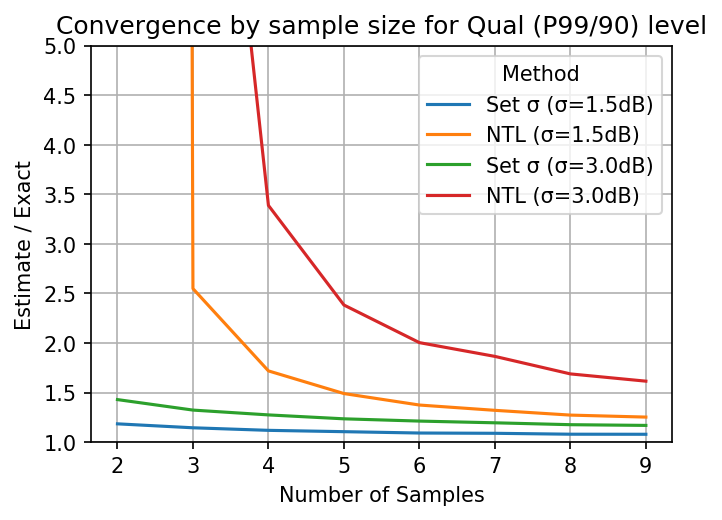

In [20]:
ax = q15_to_exact.iloc[:-1].plot.line()
q30_to_exact.iloc[:-1].plot.line(ax=ax)
ax.set_ylim(1, 5)
ax.set_ylabel("Estimate / Exact")
ax.set_title("Convergence of Qual ")
ax.set_title(f"Convergence by sample size for {level} (P{p*100:g}/{c*100:g}) level");